In [28]:
import jax.numpy as jnp
from pyutils.jax.differential import *
import matplotlib.pyplot as plt

## Brownian with reset

$$dx_t = \mu dt+\sigma dW_t$$

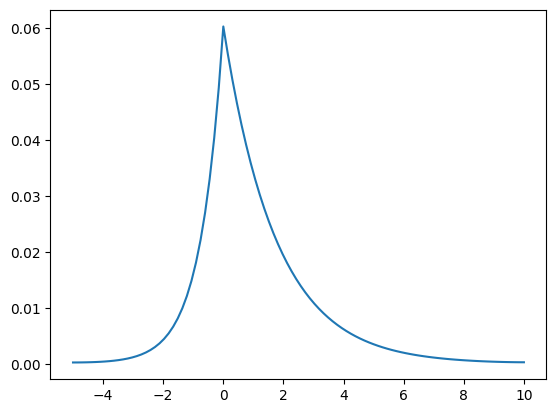

In [64]:
n = 100
x = jnp.linspace(-5,10,n)

mu = 0.1
sigma = 0.5
chi = 0.1

g_entry = jnp.zeros(n)
i = jnp.searchsorted(x, 0)
x_entry = 0
g_entry = g_entry.at[i].set((x_entry -x[i-1])/(x[i]-x[i-1]))
g_entry = g_entry.at[i-1].set((x[i]-x_entry)/(x[i]-x[i-1]))
D_x = compute_backward_derivative(x)
D_xx = compute_second_derivative(x)
g = -jnp.linalg.solve((-D_x*mu - eye(n)*chi + 1/2*D_xx*sigma**2).todense(), chi*g_entry)
fig, ax = plt.subplots()
ax.plot(x,g)
plt.show()

# Ornstein–Uhlenbeck process


$$dx_t = -\theta x_t dt+\sigma dW_t$$

/Users/marcdelabarrera/IESE Dropbox/Marc de la Barrera/repos/inflation_vol/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/marcdelabarrera/IESE Dropbox/Marc de la Barrera/repos/inflation_vol/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


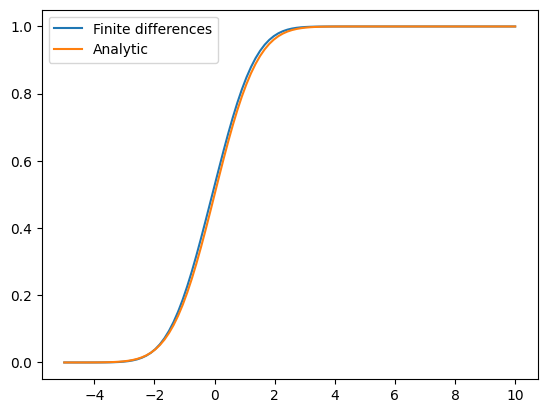

In [176]:
n = 100
x = jnp.linspace(-5,10,n)

theta = 0.1
sigma = 0.5

D_x_forward = compute_backward_derivative(x)
D_x_backward = compute_forward_derivative(x)
D_xx = compute_second_derivative(x)

mu_x = -theta*x

A = (-D_x_forward@spdiagm(jnp.where(mu_x<0, mu_x,0)) - D_x_backward@spdiagm(jnp.where(mu_x>0, mu_x,0)) + 1/2*D_xx*sigma**2).todense()
val, vec = jnp.linalg.eig(A)
g = vec[:,jnp.argmin(jnp.abs(val))]
fig, ax = plt.subplots()
ax.plot(x, jnp.cumsum(g)/jnp.sum(g), label="Finite differences")
ax.plot(x, jax.scipy.stats.norm.cdf(x, 0, jnp.sqrt(sigma**2/(2*theta))), label='Analytic')
plt.legend()
plt.show()

# Cox-Ingersoll-Ross model

$$dx_t = a(b-x_t)+\sigma\sqrt{x}dW_t$$

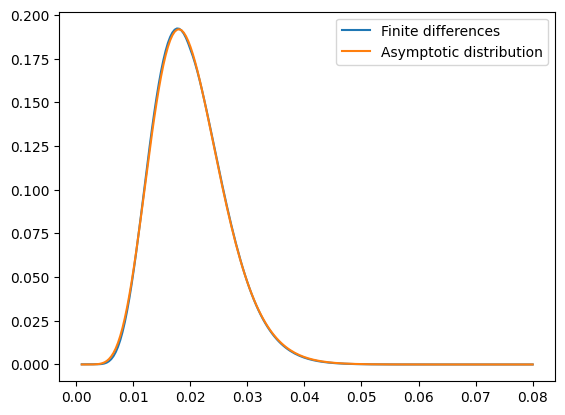

In [170]:
from jax.scipy.special import gamma

n = 200
x = jnp.linspace(0.001,0.08,n)

a = 0.1
b = 0.02
sigma = 0.02


D_x_forward = compute_backward_derivative(x)
D_x_backward = compute_forward_derivative(x)
D_xx = compute_second_derivative(x)

mu_x = a*(b-x)
sigma_x = sigma*jnp.sqrt(x)
beta = 2*a/sigma**2
alpha = 2*a*b/sigma**2
analitical_dist = beta**alpha/gamma(alpha)*x**(alpha-1)*jnp.exp(-beta*x)


A = (-D_x_forward@spdiagm(jnp.where(mu_x<0, mu_x, 0)) - D_x_backward@spdiagm(jnp.where(mu_x>0, mu_x, 0)) + 1/2*D_xx@spdiagm(sigma_x**2)).todense()
val, vec = jnp.linalg.eig(A)
g = vec[:,jnp.argmin(jnp.abs(val))]
g = -g if jnp.sum(g)<0 else g
fig, ax = plt.subplots()
ax.plot(x, g, label="Finite differences")
ax.plot(x, analitical_dist*(jnp.sum(g)/jnp.sum(analitical_dist)), label='Asymptotic distribution')
plt.legend()
plt.show()

In [173]:
sigma_x

Array([0.00063246, 0.00074753, 0.00084711, 0.00093615, 0.00101744,
       0.00109269, 0.00116308, 0.00122945, 0.00129242, 0.00135246,
       0.00140994, 0.00146517, 0.0015184 , 0.00156982, 0.0016196 ,
       0.00166791, 0.00171485, 0.00176054, 0.00180507, 0.00184854,
       0.001891  , 0.00193253, 0.00197319, 0.00201302, 0.00205209,
       0.00209042, 0.00212806, 0.00216505, 0.00220142, 0.00223719,
       0.0022724 , 0.00230708, 0.00234124, 0.00237491, 0.00240811,
       0.00244086, 0.00247317, 0.00250507, 0.00253657, 0.00256768,
       0.00259841, 0.00262879, 0.00265882, 0.00268852, 0.00271789,
       0.00274695, 0.0027757 , 0.00280416, 0.00283233, 0.00286023,
       0.00288785, 0.00291522, 0.00294233, 0.00296919, 0.00299581,
       0.0030222 , 0.00304835, 0.00307429, 0.00310001, 0.00312551,
       0.00315082, 0.00317591, 0.00320082, 0.00322553, 0.00325005,
       0.00327439, 0.00329855, 0.00332253, 0.00334634, 0.00336998,
       0.00339346, 0.00341678, 0.00343994, 0.00346294, 0.00348

In [149]:
A = A.at[10,:].set(jnp.zeros(n))
A = A.at[10,10].set(1)
g = jnp.zeros(n)
g = g.at[10].set(0.1)

g = jnp.linalg.solve(A.T, g)
A = (-D_x_forward@spdiagm(jnp.where(mu_x<0, mu_x, 0)) - D_x_backward@spdiagm(jnp.where(mu_x>0, mu_x, 0)) + 1/2*D_xx@spdiagm(sigma_x**2)).todense()


In [150]:
jnp.linalg.norm(A@g)

Array(0.4333593, dtype=float32)

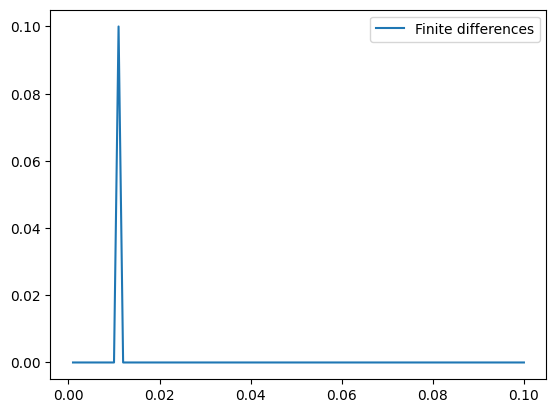

In [151]:
fig, ax = plt.subplots()
ax.plot(x, g, label="Finite differences")
plt.legend()
plt.show()